In [ ]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, f1_score
from torch.utils.data import DataLoader, Dataset

In [ ]:
from google.colab import drive
# Mount Google Drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# Custom Dataset
class DepressionDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return torch.tensor(self.features[idx], dtype=torch.float32), torch.tensor(self.labels[idx], dtype=torch.float32)

In [ ]:
# Neural Network Model with Dropout
class DepressionModel(nn.Module):
    def __init__(self, input_dim):
        super(DepressionModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.relu = nn.ReLU()
        self.dropout1 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(128, 64)
        self.dropout2 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(64, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout1(x)
        x = self.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.sigmoid(self.fc3(x))
        return x


In [ ]:
# Load and preprocess data
json_file_path = '/content/gdrive/MyDrive/ABC/data/P08.json'
phq9_file_path = '/content/gdrive/MyDrive/ABC/groundtruth/phq9.csv'

phq9_data = pd.read_csv(phq9_file_path)
phq9_data = phq9_data.replace('NA', None)
phq9_data['start_phq9'] = pd.to_numeric(phq9_data['start_phq9'], errors='coerce')
phq9_data['end_phq9'] = pd.to_numeric(phq9_data['end_phq9'], errors='coerce')

# Enhanced Labeling Logic
phq9_data['depression_label'] = phq9_data.apply(
    lambda row: 1 if (row['start_phq9'] and row['start_phq9'] >= 10) or (row['end_phq9'] and row['end_phq9'] >= 10) else 0, axis=1
)

with open(json_file_path) as f:
    json_data = json.load(f)


In [ ]:
# Helper function to pad or truncate lists
def pad_or_truncate(lst, target_len, pad_value=0):
    if len(lst) > target_len:
        return lst[:target_len]
    return lst + [pad_value] * (target_len - len(lst))

# Set fixed lengths for variable-length features
MAX_CONTOURS = 50
MAX_LANDMARKS = 68

In [ ]:
# Extract features
features_list = []
labels = []
for idx, item in enumerate(json_data):
    try:
        au_features = list(item['au'].values())
        head_pose = list(item['headEulerAngle'].values())
        bounding_box = [float(x) for x in item['boundingBox'].split()]
        classification = list(item['classification'].values())

        contours_x = pad_or_truncate([contour['x'] for contour in item['contours']], MAX_CONTOURS)
        contours_y = pad_or_truncate([contour['y'] for contour in item['contours']], MAX_CONTOURS)

        landmarks_x = pad_or_truncate([landmark['x'] for landmark in item['landmarks']], MAX_LANDMARKS)
        landmarks_y = pad_or_truncate([landmark['y'] for landmark in item['landmarks']], MAX_LANDMARKS)

        features = au_features + head_pose + bounding_box + classification + contours_x + contours_y + landmarks_x + landmarks_y

        # Debugging feature length
        expected_length = len(au_features) + len(head_pose) + len(bounding_box) + len(classification) + 2 * MAX_CONTOURS + 2 * MAX_LANDMARKS
        if len(features) != expected_length:
            print(f"Feature length mismatch at index {idx}: {len(features)} (expected {expected_length})")
            continue

        features_list.append(features)

        participant_id = item['pid']
        label = phq9_data[phq9_data['pid'] == participant_id]['depression_label'].values
        labels.append(label[0] if len(label) > 0 else 0)

    except KeyError as e:
        print(f"Missing key {e} in JSON entry at index {idx}. Skipping entry.")
    except Exception as e:
        print(f"Unexpected error at index {idx}: {e}. Skipping entry.")

In [ ]:
import matplotlib.pyplot as plt # Importing the necessary library

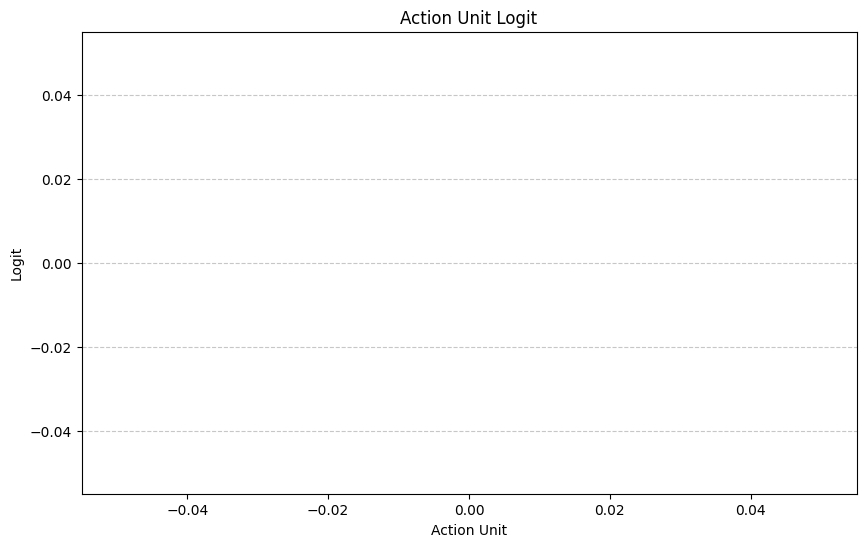

In [ ]:
# Visualize Features
# Action Units
au_names = list(json_data[0]['au'].keys())
au_values = list(json_data[0]['au'].values())
plt.figure(figsize=(10, 6))
plt.bar(au_names, au_values, color='skyblue')
plt.title('Action Unit Logit')
plt.xlabel('Action Unit')
plt.ylabel('Logit')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

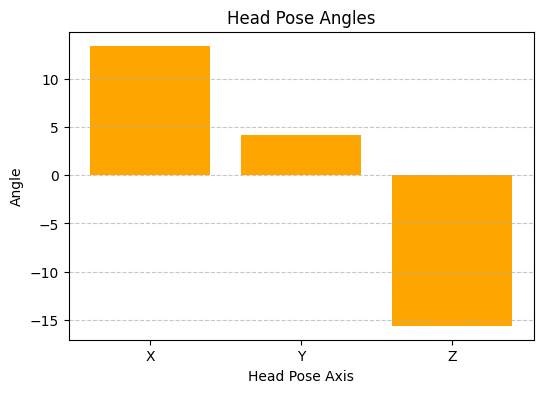

In [ ]:
# Head Pose
head_pose = list(json_data[0]['headEulerAngle'].values())
head_pose_labels = list(json_data[0]['headEulerAngle'].keys())
plt.figure(figsize=(6, 4))
plt.bar(head_pose_labels, head_pose, color='orange')
plt.title('Head Pose Angles')
plt.xlabel('Head Pose Axis')
plt.ylabel('Angle')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

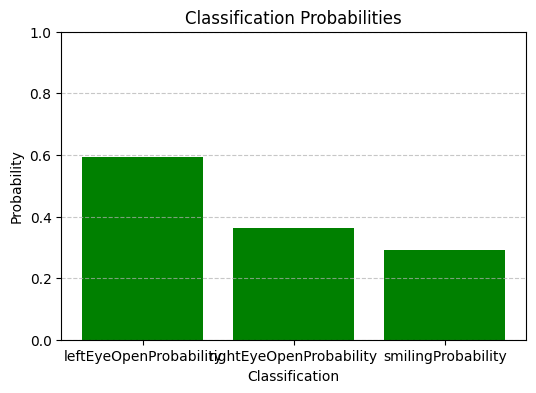

In [ ]:
# Classification Probabilities
classification = list(json_data[0]['classification'].values())
classification_labels = list(json_data[0]['classification'].keys())
plt.figure(figsize=(6, 4))
plt.bar(classification_labels, classification, color='green')
plt.title('Classification Probabilities')
plt.xlabel('Classification')
plt.ylabel('Probability')
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

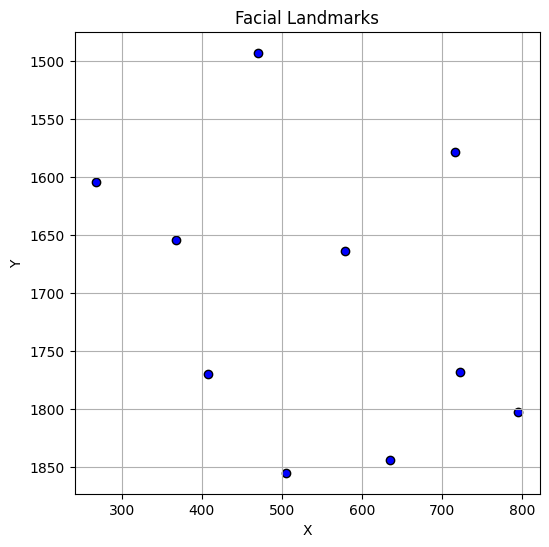

In [ ]:
# Landmarks
landmarks = json_data[0]['landmarks']
landmark_x = [point['x'] for point in landmarks]
landmark_y = [point['y'] for point in landmarks]
plt.figure(figsize=(6, 6))
plt.scatter(landmark_x, landmark_y, c='blue', edgecolors='black')
plt.title('Facial Landmarks')
plt.xlabel('X')
plt.ylabel('Y')
plt.gca().invert_yaxis()
plt.grid(True)
plt.show()


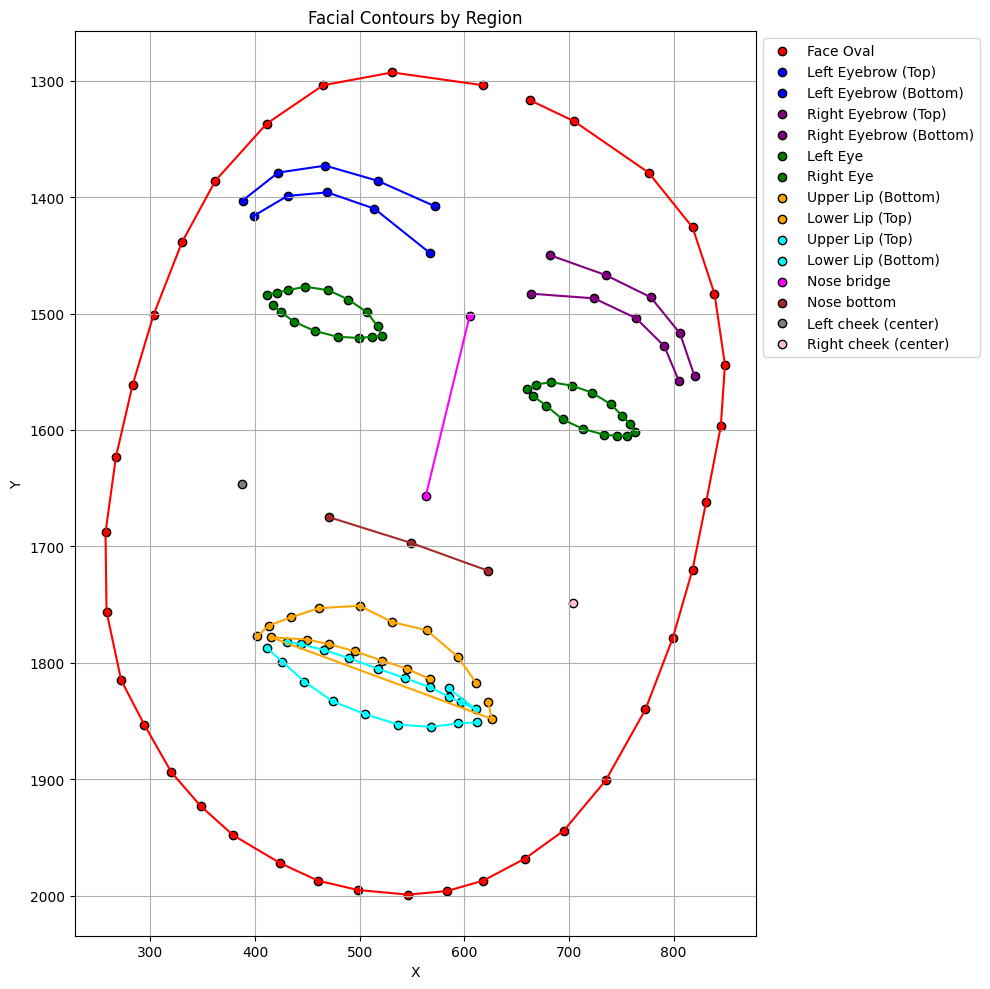

In [ ]:
# Extracting and visualizing Contours
contours = {}
if isinstance(json_data, dict) and 'contours' in json_data:
    contours = json_data['contours']
elif isinstance(json_data, list):
    for i, item in enumerate(json_data):
        if isinstance(item, dict) and 'contours' in item:
            # Assuming 'contours' contains a list of dictionaries with 'x' and 'y' keys
            if isinstance(item['contours'], list):
                for point in item['contours']:
                    if isinstance(point, dict) and 'x' in point and 'y' in point:
                        contours.setdefault('x', []).append(point['x'])
                        contours.setdefault('y', []).append(point['y'])
            # If 'contours' is a dictionary with 'x' and 'y' keys directly
            elif isinstance(item['contours'], dict) and 'x' in item['contours'] and 'y' in item['contours']:
                contours.setdefault('x', []).append(item['contours']['x'])
                contours.setdefault('y', []).append(item['contours']['y'])

if contours:
    x_contour = contours.get('x', [])
    y_contour = contours.get('y', [])

    face_parts = [
        ((0, 35), 'Face Oval', 'red'),
        ((36, 40), 'Left Eyebrow (Top)', 'blue'),
        ((41, 45), 'Left Eyebrow (Bottom)', 'blue'),
        ((46, 50), 'Right Eyebrow (Top)', 'purple'),
        ((51, 55), 'Right Eyebrow (Bottom)', 'purple'),
        ((56, 71), 'Left Eye', 'green'),
        ((72, 87), 'Right Eye', 'green'),
        ((88, 96), 'Upper Lip (Bottom)', 'orange'),
        ((97, 105), 'Lower Lip (Top)', 'orange'),
        ((106, 116), 'Upper Lip (Top)', 'cyan'),
        ((117, 125), 'Lower Lip (Bottom)', 'cyan'),
    ]
    # Nose bridge: indices 126, 127
    face_parts.append(((126, 127), 'Nose bridge', 'magenta'))

    # Nose bottom: indices 128, 129
    face_parts.append(((128, 130), 'Nose bottom', 'brown'))

    # Left cheek (center): index 131 only
    face_parts.append(((131, 131), 'Left cheek (center)', 'gray'))

    # Right cheek (center): index 132 only
    face_parts.append(((132, 132), 'Right cheek (center)', 'pink'))

    plt.figure(figsize=(10, 10))

    for (start, end), label, color in face_parts:
        x_part = x_contour[start:end+1]
        y_part = y_contour[start:end+1]
        plt.scatter(x_part, y_part, label=label, c=color, edgecolors='black')
        if end > start:
            plt.plot(x_part, y_part, c=color)

    plt.gca().invert_yaxis()
    plt.title('Facial Contours by Region')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.grid(True)
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.tight_layout()
    plt.show()

In [ ]:
# Check consistency of feature shapes
if len(features_list) > 0:
    feature_lengths = [len(f) for f in features_list]
    unique_lengths = set(feature_lengths)
    if len(unique_lengths) > 1:
        print(f"Inconsistent feature lengths detected: {unique_lengths}")
        # Find the maximum feature length
        max_length = max(unique_lengths)

        # Pad or truncate features to the maximum length
        features_list = [pad_or_truncate(f, max_length) for f in features_list]

    else:
        print(f"All features have consistent length: {list(unique_lengths)[0]}")

# Convert to NumPy array
try:
    features_array = np.array(features_list)
    labels_array = np.array(labels)
except ValueError as e:
    print(f"Error converting features to NumPy array: {e}")
    raise

Inconsistent feature lengths detected: {258, 243, 246, 255}


In [ ]:
# Normalize features
scaler = StandardScaler()
features_array = scaler.fit_transform(features_array)


In [ ]:
# Stratified K-Fold Cross-Validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
kfold_results = []

for fold, (train_idx, test_idx) in enumerate(skf.split(features_array, labels_array)):
    print(f"\nFold {fold + 1}")

    X_train, X_test = features_array[train_idx], features_array[test_idx]
    y_train, y_test = labels_array[train_idx], labels_array[test_idx]

    train_dataset = DepressionDataset(X_train, y_train)
    test_dataset = DepressionDataset(X_test, y_test)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    input_dim = X_train.shape[1]
    model = DepressionModel(input_dim)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Training
    epochs = 10
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for features, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(features).squeeze()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader):.4f}")

    # Evaluation
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for features, labels in test_loader:
            outputs = model(features).squeeze()
            preds = (outputs > 0.5).float()
            all_preds.extend(preds.numpy())
            all_labels.extend(labels.numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    roc_auc = roc_auc_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    cm = confusion_matrix(all_labels, all_preds)

    print(f"Fold {fold + 1} Accuracy: {accuracy:.4f}")
    print(f"Fold {fold + 1} ROC-AUC: {roc_auc:.4f}")
    print(f"Fold {fold + 1} F1-Score: {f1:.4f}")
    print(f"Confusion Matrix:\n{cm}")

    kfold_results.append({
        "accuracy": accuracy,
        "roc_auc": roc_auc,
        "f1_score": f1,
        "confusion_matrix": cm
    })


Fold 1
Epoch 1/10, Loss: 0.0051
Epoch 2/10, Loss: 0.0000
Epoch 3/10, Loss: 0.0000
Epoch 4/10, Loss: 0.0000
Epoch 5/10, Loss: 0.0000
Epoch 6/10, Loss: 0.0000
Epoch 7/10, Loss: 0.0000
Epoch 8/10, Loss: 0.0000
Epoch 9/10, Loss: 0.0000
Epoch 10/10, Loss: 0.0000


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:375: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


Fold 1 Accuracy: 1.0000
Fold 1 ROC-AUC: nan
Fold 1 F1-Score: 0.0000
Confusion Matrix:
[[9335]]

Fold 2
Epoch 1/10, Loss: 0.0053
Epoch 2/10, Loss: 0.0000
Epoch 3/10, Loss: 0.0000
Epoch 4/10, Loss: 0.0000
Epoch 5/10, Loss: 0.0000
Epoch 6/10, Loss: 0.0000
Epoch 7/10, Loss: 0.0000
Epoch 8/10, Loss: 0.0000
Epoch 9/10, Loss: 0.0000
Epoch 10/10, Loss: 0.0000


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:375: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


Fold 2 Accuracy: 1.0000
Fold 2 ROC-AUC: nan
Fold 2 F1-Score: 0.0000
Confusion Matrix:
[[9334]]

Fold 3
Epoch 1/10, Loss: 0.0053
Epoch 2/10, Loss: 0.0000
Epoch 3/10, Loss: 0.0000
Epoch 4/10, Loss: 0.0000
Epoch 5/10, Loss: 0.0000
Epoch 6/10, Loss: 0.0000
Epoch 7/10, Loss: 0.0000
Epoch 8/10, Loss: 0.0000
Epoch 9/10, Loss: 0.0000
Epoch 10/10, Loss: 0.0000


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:375: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


Fold 3 Accuracy: 1.0000
Fold 3 ROC-AUC: nan
Fold 3 F1-Score: 0.0000
Confusion Matrix:
[[9334]]

Fold 4
Epoch 1/10, Loss: 0.0044
Epoch 2/10, Loss: 0.0000
Epoch 3/10, Loss: 0.0000
Epoch 4/10, Loss: 0.0000
Epoch 5/10, Loss: 0.0000
Epoch 6/10, Loss: 0.0000
Epoch 7/10, Loss: 0.0000
Epoch 8/10, Loss: 0.0000
Epoch 9/10, Loss: 0.0000
Epoch 10/10, Loss: 0.0000


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:375: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


Fold 4 Accuracy: 1.0000
Fold 4 ROC-AUC: nan
Fold 4 F1-Score: 0.0000
Confusion Matrix:
[[9334]]

Fold 5
Epoch 1/10, Loss: 0.0038
Epoch 2/10, Loss: 0.0000
Epoch 3/10, Loss: 0.0000
Epoch 4/10, Loss: 0.0000
Epoch 5/10, Loss: 0.0000
Epoch 6/10, Loss: 0.0000
Epoch 7/10, Loss: 0.0000
Epoch 8/10, Loss: 0.0000
Epoch 9/10, Loss: 0.0000
Epoch 10/10, Loss: 0.0000
Fold 5 Accuracy: 1.0000
Fold 5 ROC-AUC: nan
Fold 5 F1-Score: 0.0000
Confusion Matrix:
[[9334]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:375: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


In [ ]:

# Summarize Cross-Validation Results
mean_accuracy = np.mean([result['accuracy'] for result in kfold_results])
mean_roc_auc = np.mean([result['roc_auc'] for result in kfold_results])
mean_f1 = np.mean([result['f1_score'] for result in kfold_results])

print(f"\nMean Accuracy: {mean_accuracy:.4f}")
print(f"Mean ROC-AUC: {mean_roc_auc:.4f}")
print(f"Mean F1-Score: {mean_f1:.4f}")


Mean Accuracy: 1.0000
Mean ROC-AUC: nan
Mean F1-Score: 0.0000


In [ ]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(features_array, labels_array, test_size=0.2, random_state=42)

In [ ]:
# Create DataLoader
train_dataset = DepressionDataset(X_train, y_train)
test_dataset = DepressionDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Model, Loss, Optimizer
input_dim = X_train.shape[1]
model = DepressionModel(input_dim)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# Training
epochs = 10
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for features, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(features).squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader):.4f}")

In [ ]:
# Evaluation
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for features, labels in test_loader:
        outputs = model(features).squeeze()
        preds = (outputs > 0.5).float()
        all_preds.extend(preds.numpy())
        all_labels.extend(labels.numpy())

accuracy = accuracy_score(all_labels, all_preds)
print(f"Test Accuracy: {accuracy:.4f}")
print("Classification Report:\n", classification_report(all_labels, all_preds))